<a href="https://colab.research.google.com/github/vannguyenhoai43-hash/ecommerce-category-growth-analysis/blob/main/notebooks/01_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phân tích tăng trưởng theo Level 1 ngành hàng

Tại bước này, dữ liệu được nhóm theo Level 1 ngành hàng để tính:
- Chênh lệch tuyệt đối ADO & GMV theo MoM
- Tốc độ tăng trưởng tương đối
- Vẽ chart tương quan giữa ADO và GMV theo tháng

Mục tiêu là so sánh **mức độ đóng góp tăng thai trưởng** giữa các ngành hàng chính.

**Thực hiện:** Nhóm theo level 1 và vẽ chart theo tháng trong dữ liệu

### Upload data

In [1]:
# chạy lại repo
%cd /content
!rm -rf ecommerce-category-growth-analysis

/content


In [2]:
!git clone https://github.com/vannguyenhoai43-hash/ecommerce-category-growth-analysis.git

Cloning into 'ecommerce-category-growth-analysis'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 80 (delta 27), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (80/80), 1.07 MiB | 5.11 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [11]:
# check
%cd /content/ecommerce-category-growth-analysis
!ls

/content/ecommerce-category-growth-analysis
notebooks  README.md  src


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys
sys.path.append("/content/ecommerce-category-growth-analysis/src")

from load_data import load_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#check return của load data
data = load_data("2024-09")
type(data)

dict

## Lấy data ngành hàng

In [28]:
# Lấy data tất cả các tháng
df_source_lv2 = load_data("2024-09")["source_lv2"]

In [29]:
# Lấy data tháng hiện tại
df_cur_lv2 = load_data("2024-09")["cur_lv2"]

## Hàm tăng trưởng

In [15]:
def _growth(df_cat):

  ado_m = df_cat['ADO_M'].sum()
  ado_m1 = df_cat['ADO_M_1'].sum()
  gmv_m = df_cat['AdGMV_M'].sum()
  gmv_m1 = df_cat['AdGMV_M_1'].sum()

  return {
  'diff_ado' : ado_m - ado_m1,
  'diff_gmv' : gmv_m - gmv_m1,
  'grow_ado' : (ado_m - ado_m1) / ado_m1  if ado_m1 != 0 else 0,
  'grow_gmv':(gmv_m - gmv_m1) / gmv_m1  if gmv_m1 != 0 else 0,
}

In [16]:
import pandas as pd

# hàm tăng trưởng nhiều level
def growth_by_mul_level(df, level_cols):
    results = []

    base_col = ['ADO_M','ADO_M_1','AdGMV_M','AdGMV_M_1']

    for level_values, sub_df in df.groupby(level_cols):

        # tính growth cho từng group
        res = _growth(sub_df)

        # Giữ lại base col
        for c in base_col:
          res[c]=sub_df[c].sum()

        # gắn lại từng level vào kết quả
        for col, val in zip(level_cols, level_values):
            res[col] = val

        results.append(res)

    return pd.DataFrame(results)

In [18]:
# Bảng ADO/GMV theo tháng của lv1
l1_by_month = (df_source_lv2
              .groupby(['year_month','level1_kpi_category'])
              .agg({'ADO_M':'sum','AdGMV_M':'sum'})
              .reset_index()
              )
l1_by_month

,year_month,level1_kpi_category,ADO_M,AdGMV_M
0,2024-07,Automotive,28612.853177,162052.383981
1,2024-07,Tools & Home Improvement,14404.819563,92790.688823
2,2024-08,Automotive,30782.390456,174524.614914
3,2024-08,Tools & Home Improvement,14529.022784,95825.641870
4,2024-09,Automotive,31641.407527,178283.670125
5,2024-09,Tools & Home Improvement,15099.169643,107792.143755


## Hàm chart

In [19]:
import matplotlib.pyplot as plt

def plot_gmv_ado_dual_chart(df):


    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

    categories = ['Automotive', 'Tools & Home Improvement']

    for ax, cat in zip(axes, categories):
        data = df[df['level1_kpi_category'] == cat].sort_values('year_month')

        # Bar chart - GMV
        ax.bar(data['year_month'], data['AdGMV_M'], width=0.5, alpha=0.8)
        ax.set_title(f"{cat} - GMV & ADO")
        ax.set_xlabel("Year-Month")
        ax.set_ylabel("GMV")

        # Line chart - ADO (secondary axis)
        ax2 = ax.twinx()
        ax2.plot(data['year_month'], data['ADO_M'],color='darkorange', marker='o')
        ax2.set_ylabel("ADO")

        # X label xoay cho dễ đọc
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

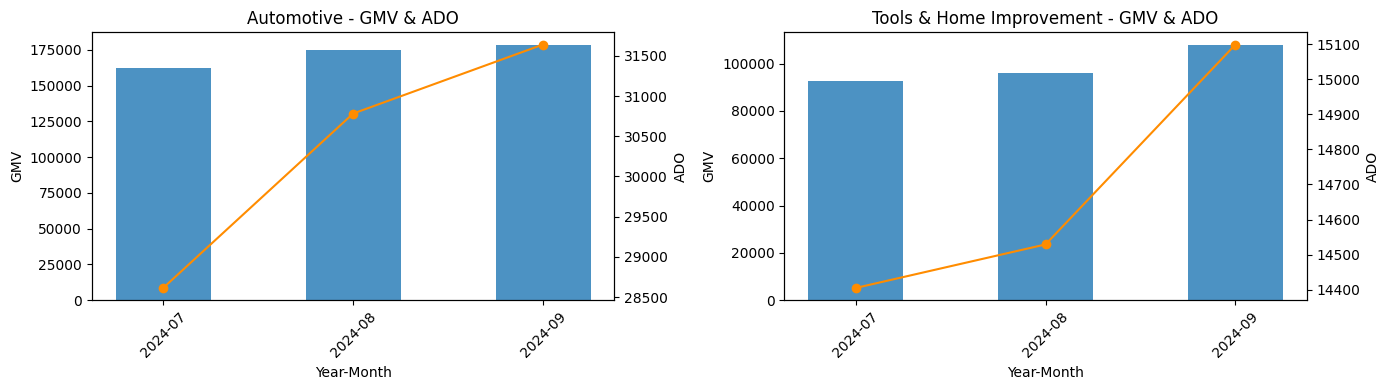

In [20]:
plot_gmv_ado_dual_chart(l1_by_month)